# InfoNCE

## Setup

The following cell imports the necessary packages:

In [11]:
import torch
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
import argparse
from src.utils import *
from src.mi_estimators import *
from torch.utils.tensorboard import SummaryWriter

Set random seed for reproducibility.

In [12]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
torch.set_default_tensor_type(FloatTensor)

Specify the hyper-parameters:

In [13]:
parser = argparse.ArgumentParser()
parser.add_argument("--rho", type=float, default=0.9, help="coefficient of Gaussian")
parser.add_argument("--d", type=int, default=20, help="dimension of X & Y")
parser.add_argument("--sample_size", type=int, default=400, help="sample size")
parser.add_argument("--gamma", type=float, default=1e-10, help="clipping parameter")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--batch_size", type=int, default=40, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-3, help="adam: learning rate")
parser.add_argument("--hidden_dim", type=int, default=100, help="Hidden dimension")
parser.add_argument("--hidden_layer", type=int, default=2, help="the number of hidden layers")
parser.add_argument("--ma_rate", type=float, default=0.1, help="move average rate")
parser.add_argument("--ma_ef", type=float, default=1, help="move average ef")
parser.add_argument("--exc", type=int, default=1, help="whether exclude the data sample from the reference samples")
parser.add_argument("--reg", type=int, default=1, help="if apply regularization")
parser.add_argument("--n_epoch", type=int, default=2000, help="number of epochs of training")
parser.add_argument("--n_iters_1epoch", type=int, default=10, help="number of epochs of training")

opt, unknown = parser.parse_known_args()
opt.n_iters = opt.n_epoch * opt.n_iters_1epoch
ma_rate = 0.01  # moving average rate

In [14]:
continue_train = True  # set to True to continue to train
load_available = False # set to False to prevent loading previous results
overwrite = False  # set to True to overwrite previously stored results

Generate the data.

In [15]:
data = GaussianData(opt.sample_size, d=opt.d, rho=opt.rho)
X, Y, XY, Ground_truth = data.X, data.Y, torch.cat((data.X, data.Y), dim=1), data.mutual_information()

## Initialize the Model

In [16]:
name = f'./results/InfoNCE_dim{opt.d}_reg{opt.reg}'   # filename
chkpt_name = name+'.pt'      # checkpoint

from datetime import datetime
TIMESTAMP = "{0:%Y-%m-%dT%H-%M-%S/}".format(datetime.now())
writer = SummaryWriter(f'./results/log/InfoNCE_dim{opt.d}_reg{opt.reg}/{TIMESTAMP}')
discriminator = Net(input_size=opt.d*2, hidden_layers=opt.hidden_layer, hidden_size=opt.hidden_dim)

# move NN model to GPU if GPU is available
if cuda:
    discriminator.cuda()

# Adam optimizer
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Define the original InfoNCE loss function and its exclusion version

In [17]:
def infonce_loss(net, x_samples, y_samples, writer=None, epoch=None, reg=False):
    sample_size = x_samples.shape[0]
    x_tile = x_samples.unsqueeze(0).repeat((sample_size, 1, 1))
    y_tile = y_samples.unsqueeze(1).repeat((1, sample_size, 1))

    T0 = net(torch.cat([x_samples,y_samples], dim = -1))
    T1 = net(torch.cat([x_tile, y_tile], dim = -1))
    a = T0.mean()
    b = T1.logsumexp(dim = 1).mean() - np.log(sample_size)
    if reg:
        lower_bound = a - b - b**2
    else:
        lower_bound = a - b

    if writer is not None:
        writer.add_scalar('a', a, epoch)
        writer.add_scalar('b', b, epoch)
        writer.add_scalar('log ratio', a-b-np.log(sample_size), epoch)
    return lower_bound

In [18]:
def infonce_exc_loss(net, x_samples, y_samples, writer=None, epoch=None, reg=False):
    sample_size = x_samples.shape[0]
    x_tile = x_samples.unsqueeze(1).repeat((1, sample_size, 1))
    y_tile = y_samples.unsqueeze(0).repeat((sample_size, 1, 1))
    mask =  torch.ones([sample_size]).diag().unsqueeze(-1).bool().cuda()
    T0 = net(torch.cat([x_samples,y_samples], dim = -1))
    T1 = net(torch.cat([x_tile, y_tile], dim = -1))
    a = T0.mean()
    # b = T1[~mask].reshape(sample_size-1, -1, 1).logsumexp(dim = 0).mean() - np.log(sample_size-1)
    b = T1[~mask].reshape(-1, sample_size-1, 1).logsumexp(dim = 1).mean() - np.log(sample_size-1)

    if reg:
        lower_bound = a - b - b**2
    else:
        lower_bound = a - b

    if writer is not None:
        writer.add_scalar('a', a, epoch)
        writer.add_scalar('b', b, epoch)
    return lower_bound

Load previous results.

In [19]:
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    model_state = checkpoint['model_state']
    discriminator.load_state_dict(model_state)
    print('Previous results loaded.')
else:
    mi_list = [] # storing the mi estimation of each iteration

## Training

Since maximizing the infoNCE bound over $f$ attains the mutual information

\begin{align}
I(X\wedge Y) = \sup_{f} I_{\text{infoNCE}}(f),
\end{align}

we train the neural network to minimize the loss $-I_{\text{infoNCE}}(f)$. The optimal solution $f$ satisfies

\begin{align}
f(x,y)=\log \frac{p_{Y|X}(y|x)}{p_{Y}(y)} + c \quad \forall x\in \mathcal{X}, y \in \mathcal{Y}
\end{align}

for any constant $c$.

The following cell train the neural network using the data samples.

In [20]:
# continue_train = True  # set to True to continue to train
if continue_train:
    iter_ = 0
    for i in range(opt.n_epoch*opt.n_iters_1epoch):
        data_joint = resample(XY, batch_size=opt.batch_size)
        train_x = data_joint[:,0:opt.d]
        train_y = data_joint[:,opt.d:]
        optimizer_D.zero_grad()
        loss = -infonce_loss(discriminator, train_x, train_y, reg=opt.reg) # negative infonce_bound as the loss
        loss.backward()

        optimizer_D.step()
        with torch.no_grad():
            # mi_est = infonce_loss(discriminator, X, Y, writer, i)
            mi_est = infonce_loss(discriminator, X, Y)
        mi_list.append(mi_est.item())
        writer.add_scalar('mi_list', mi_est.item(), i)
        writer.add_scalar('loss', loss, i)
        iter_ += 1

        if iter_%1000==0:
            print("Iternation: %d, loss: %f, mi_est: %f"%(iter_, loss.item(), mi_est))
            fig = plot_fig(discriminator, X, Y, d= opt.d if opt.d<6 else 6 )
            writer.add_figure('heatmap', fig, i)
            writer.add_histogram('first layer', discriminator.fc[0].weight.data, i)
            writer.add_histogram('second layer', discriminator.fc[1].weight.data, i)
            writer.add_histogram('third layer', discriminator.fc[2].weight.data, i)
            writer.add_histogram('first layer (grad)', discriminator.fc[0].weight.grad.data, i)
            writer.add_histogram('second layer (grad)', discriminator.fc[1].weight.grad.data, i)
            writer.add_histogram('third layer (grad)', discriminator.fc[2].weight.grad.data, i)

# writer.add_graph(discriminator, (XY,))
writer.close()

Iternation: 1000, loss: -3.520541, mi_est: 5.165650
Iternation: 2000, loss: -3.606558, mi_est: 5.368244
Iternation: 3000, loss: -3.624501, mi_est: 5.577556
Iternation: 4000, loss: -3.631473, mi_est: 5.675043
Iternation: 5000, loss: -3.657409, mi_est: 5.702077
Iternation: 6000, loss: -3.644025, mi_est: 5.764727
Iternation: 7000, loss: -3.548501, mi_est: 5.823317
Iternation: 8000, loss: -3.545374, mi_est: 5.821674
Iternation: 9000, loss: -3.621763, mi_est: 5.848138
Iternation: 10000, loss: -3.638602, mi_est: 5.857751
Iternation: 11000, loss: -3.673408, mi_est: 5.853169
Iternation: 12000, loss: -3.656627, mi_est: 5.877774
Iternation: 13000, loss: -3.660640, mi_est: 5.900066
Iternation: 14000, loss: -3.683092, mi_est: 5.909502
Iternation: 15000, loss: -3.513114, mi_est: 5.910598
Iternation: 16000, loss: -3.678657, mi_est: 5.925441
Iternation: 17000, loss: -3.644468, mi_est: 5.909424
Iternation: 18000, loss: -3.629365, mi_est: 5.936130
Iternation: 19000, loss: -3.673980, mi_est: 5.942770
It

In [21]:
if overwrite or not os.path.exists(chkpt_name):
    model_state = discriminator.state_dict()
    torch.save({
        'mi_list': mi_list,
        'model_state': model_state
    }, chkpt_name)
    writer.close()
    print('Current results saved.')

Current results saved.


## MI estimates

Use moving average to smooth the estimated MI in each training iteration.

In [22]:
mi_copy = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy[k] = (1-ma_rate) * mi_copy[k-1] + ma_rate * mi_copy[k]

Plot the MI estimation curve against the training iteration, together with the ground truth.

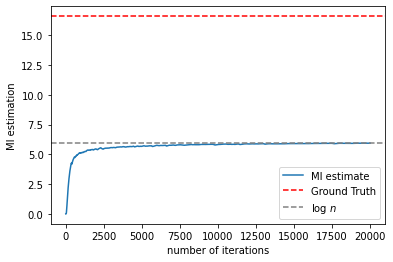

In [23]:
plt.plot(mi_copy, label='MI estimate')
plt.axhline(Ground_truth,label='Ground Truth',linestyle='--',color='red')
plt.axhline(np.log(opt.sample_size),label='log $n$',linestyle='--',color='grey')
# for t in range(len(mi_copy)):
#     if (mi_copy[t]>.8*Ground_truth):
#         plt.axvline(t,label='80% reached',linestyle=':',color='green')
#         break
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.legend()
# plt.savefig(f'./results/InfoNCE_dim{opt.d}_reg{opt.reg}.pdf')

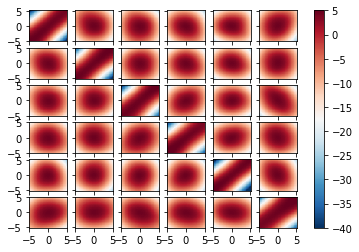

In [24]:
heatmap = plot_fig(discriminator, X, Y, vmin=-40, vmax=5, d=6)
# plt.savefig(f'./results/heatmap_InfoNCE_dim{opt.d}_reg{opt.reg}.pdf')

## InfoNCE w\o data samples (exclusion)

In [25]:
name = f'./results/InfoNCE_exc_dim{opt.d}_reg{opt.reg}'   # filename
chkpt_name = name+'.pt'      # checkpoint
# opt.reg = 0
from datetime import datetime
TIMESTAMP = "{0:%Y-%m-%dT%H-%M-%S/}".format(datetime.now())
writer = SummaryWriter(f'./results/log/InfoNCE_exc_dim{opt.d}_reg{opt.reg}/{TIMESTAMP}')
discriminator2 = Net(input_size=opt.d*2, hidden_layers=opt.hidden_layer, hidden_size=opt.hidden_dim)

# move NN model to GPU if GPU is available
if cuda:
    discriminator2.cuda()

# Adam optimizer
optimizer_D = torch.optim.Adam(discriminator2.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [26]:
# load_available = True # set to False to prevent loading previous results
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    model_state = checkpoint['model_state']
    discriminator2.load_state_dict(model_state)
    print('Previous results loaded.')
else:
    mi_list = [] # storing the mi estimation of each iteration

In [27]:
if continue_train:
    for i in range(opt.n_epoch*opt.n_iters_1epoch):
        data_joint = resample(XY, batch_size=opt.batch_size)
        train_x = data_joint[:,0:opt.d]
        train_y = data_joint[:,opt.d:]

        optimizer_D.zero_grad()
        loss = -infonce_exc_loss(discriminator2, train_x, train_y, reg=opt.reg) # negative infonce_bound as the loss
        loss.backward()

        optimizer_D.step()
        with torch.no_grad():
            mi_est = infonce_exc_loss(discriminator2, X, Y, writer, i)
        mi_list.append(mi_est.item())
        writer.add_scalar('mi_list', mi_est.item(), i)
        writer.add_scalar('loss', loss, i)

        if i%1000==0:
            print("Iternation: %d, loss: %f, mi_est: %f"%(i, loss.item(), mi_est))
            fig = plot_fig(discriminator2, X, Y, d=opt.d if opt.d<6 else 6)
            writer.add_figure('heatmap', fig, i)
            writer.add_histogram('first layer', discriminator2.fc[0].weight.data, i)
            writer.add_histogram('second layer', discriminator2.fc[1].weight.data, i)
            writer.add_histogram('third layer', discriminator2.fc[2].weight.data, i)
            writer.add_histogram('first layer (grad)', discriminator2.fc[0].weight.grad.data, i)
            writer.add_histogram('second layer (grad)', discriminator2.fc[1].weight.grad.data, i)
            writer.add_histogram('third layer (grad)', discriminator2.fc[2].weight.grad.data, i)

# writer.add_graph(discriminator2, (XY,))
writer.close()

Iternation: 0, loss: -0.000032, mi_est: 0.000157
Iternation: 1000, loss: -10.654895, mi_est: 14.747592
Iternation: 2000, loss: -40.510338, mi_est: 32.592831
Iternation: 3000, loss: -30.943605, mi_est: 47.957245
Iternation: 4000, loss: -86.601303, mi_est: 65.351837
Iternation: 5000, loss: -104.434311, mi_est: 100.258987
Iternation: 6000, loss: -155.542694, mi_est: 137.123764
Iternation: 7000, loss: -67.506241, mi_est: 193.971741
Iternation: 8000, loss: -269.856781, mi_est: 274.071350
Iternation: 9000, loss: -459.001099, mi_est: 392.638580
Iternation: 10000, loss: -468.424408, mi_est: 532.657837
Iternation: 11000, loss: -540.113892, mi_est: 734.549927
Iternation: 12000, loss: -1017.125549, mi_est: 963.867249
Iternation: 13000, loss: -1164.823242, mi_est: 1237.902588
Iternation: 14000, loss: -1553.563721, mi_est: 1608.124634
Iternation: 15000, loss: -1950.220215, mi_est: 1983.817505
Iternation: 16000, loss: -2563.796143, mi_est: 2528.517334
Iternation: 17000, loss: -2029.132812, mi_est: 3

In [28]:
mi_copy2 = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy2[k] = (1-ma_rate) * mi_copy2[k-1] + ma_rate * mi_copy2[k]

In [29]:
# overwrite = True  # set to True to overwrite previously stored results
if overwrite or not os.path.exists(chkpt_name):
    model_state = discriminator2.state_dict()
    torch.save({
        'mi_list': mi_list,
        'model_state': model_state
    }, chkpt_name)
    writer.close()
    print('Current results saved.')

Current results saved.


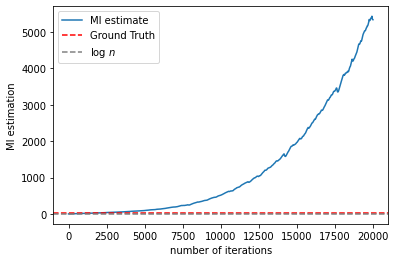

In [30]:
plt.plot(mi_copy2, label='MI estimate')
plt.axhline(Ground_truth,label='Ground Truth',linestyle='--',color='red')
plt.axhline(np.log(opt.sample_size),label='log $n$',linestyle='--',color='grey')
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.legend()
# plt.savefig(f'./results/InfoNCE_exc_dim{opt.d}_reg{opt.reg}.pdf')

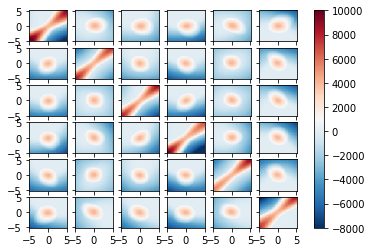

In [31]:
heatmap = plot_fig(discriminator2, X, Y, vmin=-8000, vmax=10000, d=6)
# plt.savefig(f'./results/heatmap_InfoNCE_exc_dim{opt.d}_reg{opt.reg}.pdf')

## Ground Truth Heapmap

In [32]:
def GT(x, y):
    mi = -0.5 * np.log(1 - opt.rho**2) * opt.d
    c = opt.rho / (2 * (1 - opt.rho**2))
    return mi + c * (2 * x * y - opt.rho *(x**2 + y**2)).sum(dim=1)

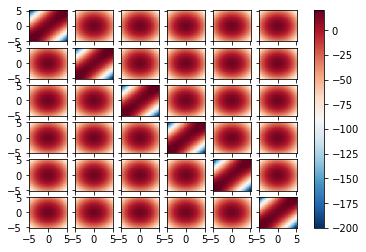

In [33]:
d = 6
DEVICE = "cuda"
f, axs = plt.subplots(nrows=d,ncols=d,sharex=True, sharey=True)
for i in range(d):
    for j in range(d):
        im = plot_subfigure_GT(GT, X, Y, dimX=i, dimY=j, x0=None, y0=None, xmin=-5, xmax=5, ymin=-5, ymax=5, xgrids=50, ygrids=50, ax=axs[i, j], show_details=False)

f.colorbar(im, ax=axs.ravel().tolist())
# plt.savefig(f'./results/GT_heatmap_dim{opt.d}.pdf')
plt.show()